In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import dvu
import seaborn as sns
import os
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
from os.path import join
import numpy as np
# import imodelsx.process_results
# import ridge_utils.features.qa_questions
import neuro.features.feature_utils
import joblib
from tqdm import tqdm
# import analyze_helper
# fit_encoding = __import__('02_fit_encoding')
dvu.set_style()

# results_dir = analyze_helper.best_results_dir
# r, cols_varied, mets = analyze_helper.load_clean_results(results_dir)
data = joblib.load('results.pkl')
r, cols_varied, mets = data['r'], data['cols_varied'], data['mets']

### Validate model weights usage

In [3]:
args = r[(r.pc_components == 100) * (r.ndelays == 8) * (r.feature_space.str.contains('qa_emb')) * (r.feature_selection_alpha < 0)
         ].sort_values(by='corrs_test_mean').iloc[-1]

In [4]:
stim_test_delayed = neuro.features.feature_utils.get_features_full(
    args, feature_space='qa_embedder',
    qa_embedding_model='meta-llama/Meta-Llama-3-8B-Instruct', story_names=['sloth'])

In [5]:
import neuro.data.response_utils

In [6]:
args.pc_components = 0
args.use_huge = False
resp_train, resp_test = neuro.data.response_utils.get_resps_full(
    args, 'UTS03', ['sloth'], ['sloth'])

In [7]:
model_params = joblib.load(
    join(args.save_dir_unique, 'model_params.pkl'))
print(args.feature_space, args.pc_components, args.ndelays)

qa_embedder 0 8


/home/chansingh/.env/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
wt = model_params['weights']
preds_test = stim_test_delayed @ wt

In [9]:
# display full
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(args)

subject                                                                             S03
pc_components                                                                         0
num_stories                                                                          -1
distill_model_path                                                                  NaN
feature_space                                                               qa_embedder
embedding_layer                                                                      -1
input_chunking_type                                                               ngram
input_chunking_size                                                                  10
feature_selection_alpha                                                            -1.0
feature_selection_frac                                                              0.5
feature_selection_stability_seeds                                                  -1.0
qa_embedding_model              

### Validate corrs

In [11]:
def _calc_corrs(preds, resp):
    corrs = []
    for i in tqdm(range(preds.shape[1])):
        corrs.append(np.corrcoef(
            preds[:, i], resp[:, i])[0, 1])
    return np.array(corrs)


wt = model_params['weights']
preds_test = stim_test_delayed @ wt
corrs_test = _calc_corrs(preds_test, resp_test)
print(np.mean(corrs_test))
print(args.corrs_test_mean)
assert np.allclose(corrs_test, args['corrs_test'])

100%|██████████| 95556/95556 [00:17<00:00, 5490.01it/s]


0.11996419844218449
0.13380407146651993


AssertionError: 

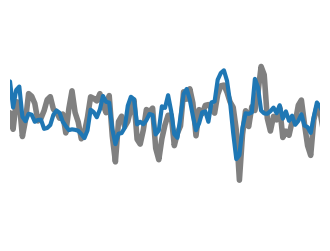

In [12]:
a = np.argmax(corrs_test)
preds_voxel_best = preds_test[:, a]
resp_voxel_best = resp_test[:, a]
plt.figure(figsize=(4, 3))
plt.plot(resp_voxel_best / np.std(resp_voxel_best), color='gray', lw=4)
plt.plot(preds_voxel_best / np.std(preds_voxel_best) /
         1.2, color='C0', lw=3)  # , resp_voxel_best, 'o')
plt.xlim((250, 350))
plt.ylim((-6, 5))
plt.xticks([])
plt.yticks([])
# remove all splines
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.savefig('../figs/ex_curve.pdf', bbox_inches='tight')
plt.savefig('../figs/ex_curve.png', bbox_inches='tight', dpi=300)

In [ ]:
wt = model_params['weights']
# + model_params_to_save['bias'] (not needed for just calculating corr, but needed for predictions)
preds_test = stim_test_delayed @ wt

corrs_test = _calc_corrs(preds_test, resp_test)
print(np.mean(corrs_test))
print(args.corrs_test_mean)
assert np.allclose(corrs_test, args['corrs_test'])

### Original setup, before we had unpacked weights

In [ ]:
import ridge_utils.data.story_names
story_names_train = ridge_utils.data.story_names.get_story_names(
    subject='UTS03', train_or_test='train')
story_names_test = ridge_utils.data.story_names.get_story_names(
    subject='UTS03', train_or_test='test')

In [ ]:
args.pc_components = 0
resp_train, resp_test = fit_encoding.get_resps_full(
    args, args.subject, story_names_train, story_names_test)

In [ ]:
wt_pc = model_params['weights_pc']
pca = model_params['pca']
scaler_test = model_params['scaler_test']
preds_pc = stim_test_delayed @ wt_pc
preds_pc_scaled = scaler_test.inverse_transform(preds_pc)
preds_voxels = pca.inverse_transform(preds_pc_scaled)
corrs_test = _calc_corrs(preds_voxels, resp_test)
assert np.allclose(corrs_test, args['corrs_test'])

In [ ]:
# Vary number of pcs included
num_pcs = [5, 25, 50, 100, 200, 500, 1000]
corrs = []
for num_pc in num_pcs:
    wt_pc = model_params['weights_pc']
    pca = fit_encoding.get_pca('UTS03')
    scaler_test = model_params['scaler_test']
    preds_pc = stim_test_delayed @ wt_pc
    preds_pc_scaled = scaler_test.inverse_transform(preds_pc)

    pca_subset = deepcopy(pca)
    pca_subset.components_[num_pc:] = 0
    preds_voxels = pca_subset.inverse_transform(preds_pc_scaled)

    corrs_test = _calc_corrs(preds_voxels, resp_test)
    # assert np.allclose(corrs_test, args['corrs_test'])
    print(num_pc, np.mean(corrs_test))
    corrs.append(np.mean(corrs_test))
plt.plot(num_pcs, corrs)

In [ ]:
corrs_test = fit_encoding.evaluate_pc_model_on_each_voxel(
    args, stim_test_delayed, resp_test,
    model_params, pca, scaler_test)

In [ ]:
wt = model_params['weights']

# multiply
preds_pc = stim_test_delayed @ wt
preds_pc_unscaled = preds_pc * scaler_test.scale_ + scaler_test.mean_
preds_voxels2 = preds_pc_unscaled @ pca.components_ + pca.mean_

# rewrite the above as a multiplication of a single weight matrix
preds_voxels2 = (stim_test_delayed @ wt * scaler_test.scale_ +
                 scaler_test.mean_) @ pca.components_ + pca.mean_
weight_full = wt * scaler_test.scale_ @ pca.components_
bias_full = scaler_test.mean_ @ pca.components_ + pca.mean_
preds_voxels2 = stim_test_delayed @ weight_full + bias_full

assert np.allclose(preds_voxels, preds_voxels2)

In [ ]:
assert corrs_test.mean() == args.corrs_test_mean